# Taxi Fare Prediction

## Importing Data

In [0]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import glob
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Connecting Google Drive with Colab to get Data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Reading Data

In [0]:
path = '/content/drive/My Drive/Data/'

Green Taxi Data

In [4]:
# Reading Data from multiple data files and combining them
all_files = glob.glob(path + 'Taxi_Data/*.csv')

li = []

for filename in all_files:
    temp_df = pd.read_csv(filename, index_col=None, header=0)
    temp_df.columns = [x.lower() for x in temp_df.columns]
    li.append(temp_df)

taxi_df = pd.concat(li, axis=0, ignore_index=True)
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16385532 entries, 0 to 16385531
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   vendorid               object 
 1   lpep_pickup_datetime   object 
 2   lpep_dropoff_datetime  object 
 3   store_and_fwd_flag     object 
 4   ratecodeid             int64  
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   dropoff_longitude      float64
 8   dropoff_latitude       float64
 9   passenger_count        float64
 10  trip_distance          float64
 11  fare_amount            float64
 12  extra                  float64
 13  mta_tax                float64
 14  tip_amount             float64
 15  tolls_amount           float64
 16  ehail_fee              float64
 17  improvement_surcharge  float64
 18  total_amount           float64
 19  payment_type           float64
 20  trip_type              float64
 21  pulocationid           float64
 22  dolocationid    

In [0]:
taxi_df.head(10)

,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,pulocationid,dolocationid,trip_type
0,2,2016-01-01 00:29:24,2016-01-01 00:39:36,N,1,-73.928642,40.680611,-73.924278,40.698044,1.0,1.46,8.0,0.5,0.5,1.86,0.0,NaN,0.3,11.16,1.0,1.0,NaN,NaN,NaN
1,2,2016-01-01 00:19:39,2016-01-01 00:39:18,N,1,-73.952675,40.723175,-73.923920,40.761379,1.0,3.56,15.5,0.5,0.5,0.00,0.0,NaN,0.3,16.80,2.0,1.0,NaN,NaN,NaN
2,2,2016-01-01 00:19:33,2016-01-01 00:39:48,N,1,-73.971611,40.676105,-74.013161,40.646072,1.0,3.79,16.5,0.5,0.5,4.45,0.0,NaN,0.3,22.25,1.0,1.0,NaN,NaN,NaN
3,2,2016-01-01 00:22:12,2016-01-01 00:38:32,N,1,-73.989502,40.669579,-74.000648,40.689034,1.0,3.01,13.5,0.5,0.5,0.00,0.0,NaN,0.3,14.80,2.0,1.0,NaN,NaN,NaN
4,2,2016-01-01 00:24:01,2016-01-01 00:39:22,N,1,-73.964729,40.682854,-73.940720,40.663013,1.0,2.55,12.0,0.5,0.5,0.00,0.0,NaN,0.3,13.30,2.0,1.0,NaN,NaN,NaN
5,2,2016-01-01 00:32:59,2016-01-01 00:39:35,N,1,-73.891144,40.746456,-73.867744,40.742111,1.0,1.37,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2.0,1.0,NaN,NaN,NaN
6,2,2016-01-01 00:34:42,2016-01-01 00:39:21,N,1,-73.896675,40.746197,-73.886192,40.745689,1.0,0.57,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2.0,1.0,NaN,NaN,NaN
7,2,2016-01-01 00:31:23,2016-01-01 00:39:36,N,1,-73.953354,40.803558,-73.949150,40.794121,1.0,1.01,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2.0,1.0,NaN,NaN,NaN
8,2,2016-01-01 00:24:40,2016-01-01 00:39:52,N,1,-73.994064,40.702816,-73.971573,40.679726,1.0,2.46,12.0,0.5,0.5,2.00,0.0,NaN,0.3,15.30,1.0,1.0,NaN,NaN,NaN
9,2,2016-01-01 00:28:59,2016-01-01 00:39:23,N,1,-73.914131,40.756641,-73.917549,40.739658,1.0,1.61,9.0,0.5,0.5,1.60,0.0,NaN,0.3,11.90,1.0,1.0,NaN,NaN,NaN


In [0]:
taxi_df.describe()

,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,pulocationid,dolocationid,trip_type
count,1.638553e+07,9.018030e+06,9.018030e+06,9.018030e+06,9.018030e+06,1.638553e+07,1.638553e+07,1.638553e+07,1.638553e+07,1.638553e+07,9.018030e+06,1.638553e+07,7.367502e+06,1.638553e+07,1.638550e+07,9.018030e+06,9.017586e+06,7.367502e+06,7.367502e+06,0.0
mean,5.879965e+01,-7.381650e+01,4.067972e+01,-7.383075e+01,4.068654e+01,6.196728e+00,1.709195e+00,6.905832e+00,7.380730e-01,3.173325e-01,1.270473e+00,1.921958e-01,1.461221e+01,8.446792e-01,8.530007e+00,1.509434e+00,1.021744e+00,1.358139e+00,2.785166e+00,NaN
std,8.226787e+01,3.013607e+00,1.655605e+00,2.815466e+00,1.546043e+00,8.844846e+00,2.516771e+00,9.505189e+00,1.712104e+00,7.571092e-01,2.656698e+00,7.920587e-01,1.186426e+01,7.064253e-01,1.097782e+01,5.259202e-01,1.458474e-01,1.025615e+00,2.938928e+00,NaN
min,1.000000e+00,-1.152825e+02,0.000000e+00,-1.153322e+02,0.000000e+00,-4.990000e+02,-4.500000e+00,-4.990000e+02,-5.141000e+01,-5.000000e+01,-6.000000e+01,-3.000000e+01,-4.990000e+02,-3.000000e-01,-4.990000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,1.000000e+00,-7.396101e+01,4.069426e+01,-7.396825e+01,4.069558e+01,1.000000e+00,5.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.800000e+00,3.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.020000e+00,NaN
50%,1.000000e+00,-7.394657e+01,4.074608e+01,-7.394551e+01,4.074643e+01,2.000000e+00,1.000000e+00,4.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.130000e+01,3.000000e-01,6.300000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.810000e+00,NaN
75%,1.070000e+02,-7.391886e+01,4.080197e+01,-7.391222e+01,4.079051e+01,8.500000e+00,2.080000e+00,1.000000e+01,1.000000e+00,5.000000e-01,2.000000e+00,3.000000e-01,1.730000e+01,1.000000e+00,1.230000e+01,2.000000e+00,1.000000e+00,1.000000e+00,3.460000e+00,NaN
max,2.650000e+02,0.000000e+00,4.316801e+01,0.000000e+00,4.811947e+01,5.005500e+03,8.322000e+02,3.498500e+03,7.140000e+02,9.000000e+02,9.000000e+02,9.021700e+02,5.006300e+03,5.000000e+00,3.499300e+03,5.000000e+00,2.000000e+00,9.000000e+00,6.985600e+02,NaN


Weather Data

In [5]:
weather_csv = 'Monthly_Weather_Raw_JFK_Updated.csv'
weather_df = pd.read_csv(path+weather_csv)
weather_df.rename(columns={'Wind (mph) - Max': 'Wind (mph) - Avg',
                           'Wind (mph) - Avg': 'Wind (mph) - Min',
                           'Wind (mph) - Max?!?': 'Wind (mph) - Max'}, 
                  inplace=True)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Month                        366 non-null    int64  
 1   Day                          366 non-null    int64  
 2   Temp. (Degrees F) - Max      366 non-null    int64  
 3   Temp. (Degrees F) - Avg      366 non-null    int64  
 4   Temp. (Degrees F) - Min      366 non-null    int64  
 5   Dew Point (Degrees F) - Max  366 non-null    int64  
 6   Dew Point (Degrees F) - Avg  366 non-null    int64  
 7   Dew Point (Degrees F) - Min  366 non-null    int64  
 8   Humidity (%) - Max           366 non-null    int64  
 9   Humidity (%) - Avg           366 non-null    int64  
 10  Humidity (%) - Min           366 non-null    int64  
 11  Sea Level Press. (in) - Max  366 non-null    float64
 12  Sea Level Press. (in) - Avg  366 non-null    float64
 13  Sea Level Press. (in

In [0]:
weather_df.head(10)

,Month,Day,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum,Event
0,1,1,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.00,NaN
1,1,2,41,38,34,22,19,17,52,47,41,30.12,30.04,29.98,10,10,10,24,13,30,0.00,NaN
2,1,3,48,42,35,27,23,21,64,49,34,29.96,29.88,29.80,10,10,10,23,14,29,0.00,NaN
3,1,4,38,27,15,25,10,-1,59,44,29,30.32,30.05,29.89,10,10,10,31,20,39,0.00,NaN
4,1,5,29,21,12,10,-2,-7,58,40,21,30.64,30.58,30.45,10,10,10,28,12,38,0.00,NaN
5,1,6,40,31,21,19,12,5,63,44,25,30.61,30.53,30.43,10,10,10,14,8,17,0.00,NaN
6,1,7,46,37,27,20,14,8,58,40,22,30.40,30.30,30.20,10,10,10,13,4,15,0.00,NaN
7,1,8,47,40,32,34,29,21,70,59,48,30.25,30.21,30.18,10,10,10,16,9,18,0.00,NaN
8,1,9,53,47,40,46,40,34,86,76,66,30.22,30.16,30.06,10,10,8,21,12,26,0.02,NaN
9,1,10,58,50,41,55,47,24,96,73,49,30.01,29.57,29.31,10,6,0,35,21,44,1.28,"Fog,Rain"


In [0]:
weather_df.describe()

,Month,Day,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Precipitation (in) - Sum
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,6.513661,15.756831,64.092896,57.021858,49.426230,49.920765,42.909836,35.734973,81.661202,62.978142,43.748634,30.141366,30.035383,29.933388,9.969945,9.423497,7.527322,22.191257,11.467213,0.097855
std,3.455958,8.823592,16.977410,16.507186,16.426966,17.743894,18.942597,20.317028,13.906142,13.535122,16.495983,0.194596,0.205746,0.218016,0.446200,1.315199,3.594984,7.152471,4.463277,0.286195
min,1.000000,1.000000,17.000000,9.000000,1.000000,-8.000000,-15.000000,-19.000000,36.000000,27.000000,11.000000,29.570000,29.350000,29.250000,2.000000,0.000000,0.000000,9.000000,4.000000,0.000000
25%,4.000000,8.000000,51.000000,44.250000,37.250000,37.000000,28.000000,20.000000,73.000000,53.000000,31.250000,30.010000,29.900000,29.810000,10.000000,10.000000,6.000000,16.000000,8.000000,0.000000
50%,7.000000,16.000000,64.000000,56.000000,47.500000,51.000000,43.000000,35.000000,86.000000,64.000000,42.000000,30.140000,30.040000,29.940000,10.000000,10.000000,10.000000,21.000000,11.000000,0.000000
75%,9.750000,23.000000,79.000000,73.000000,64.000000,65.000000,59.000000,52.000000,93.000000,73.000000,55.000000,30.250000,30.167500,30.087500,10.000000,10.000000,10.000000,28.000000,14.000000,0.020000
max,12.000000,31.000000,98.000000,89.000000,82.000000,84.000000,77.000000,75.000000,100.000000,92.000000,86.000000,30.750000,30.670000,30.500000,10.000000,10.000000,10.000000,49.000000,25.000000,2.900000


## Data Cleaning

Green Taxi Data

In [0]:
taxi_df.isnull().sum().sort_values(ascending = False)

trip_type                16385532
pulocationid              9018030
ehail_fee                 9018030
dolocationid              9018030
trip_type                 7367946
dropoff_longitude         7367502
payment_type              7367502
tip_amount                7367502
pickup_longitude          7367502
pickup_latitude           7367502
dropoff_latitude          7367502
total_amount                   28
lpep_pickup_datetime            0
lpep_dropoff_datetime           0
store_and_fwd_flag              0
ratecodeid                      0
fare_amount                     0
passenger_count                 0
trip_distance                   0
extra                           0
mta_tax                         0
tolls_amount                    0
improvement_surcharge           0
vendorid                        0
dtype: int64

In [6]:
final_taxi_df = taxi_df.drop(columns=['lpep_pickup_datetime', 
                                      'lpep_dropoff_datetime', 
                                      'trip_type',
                                      'pulocationid',
                                      'ehail_fee',
                                      'dolocationid',
                                      'trip_type',
                                      'dropoff_longitude',
                                      'payment_type',
                                      'tip_amount',
                                      'pickup_longitude',
                                      'pickup_latitude',
                                      'dropoff_latitude',
                                      'trip_type '])
final_taxi_df = final_taxi_df[final_taxi_df["total_amount"].notna()]
final_taxi_df["Date"] = taxi_df["lpep_pickup_datetime"].apply(lambda x: x.split(' ')[0])
final_taxi_df["ratecodeid"] = final_taxi_df["ratecodeid"].astype(str)
final_taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16385504 entries, 0 to 16385531
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   vendorid               object 
 1   store_and_fwd_flag     object 
 2   ratecodeid             object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   fare_amount            float64
 6   extra                  float64
 7   mta_tax                float64
 8   tolls_amount           float64
 9   improvement_surcharge  float64
 10  total_amount           float64
 11  Date                   object 
dtypes: float64(8), object(4)
memory usage: 1.6+ GB


In [0]:
final_taxi_df.head(10)

,vendorid,store_and_fwd_flag,ratecodeid,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,Date
0,2,N,1,1.0,1.46,8.0,0.5,0.5,0.0,0.3,11.16,2016-01-01
1,2,N,1,1.0,3.56,15.5,0.5,0.5,0.0,0.3,16.80,2016-01-01
2,2,N,1,1.0,3.79,16.5,0.5,0.5,0.0,0.3,22.25,2016-01-01
3,2,N,1,1.0,3.01,13.5,0.5,0.5,0.0,0.3,14.80,2016-01-01
4,2,N,1,1.0,2.55,12.0,0.5,0.5,0.0,0.3,13.30,2016-01-01
5,2,N,1,1.0,1.37,7.0,0.5,0.5,0.0,0.3,8.30,2016-01-01
6,2,N,1,1.0,0.57,5.0,0.5,0.5,0.0,0.3,6.30,2016-01-01
7,2,N,1,1.0,1.01,7.0,0.5,0.5,0.0,0.3,8.30,2016-01-01
8,2,N,1,1.0,2.46,12.0,0.5,0.5,0.0,0.3,15.30,2016-01-01
9,2,N,1,1.0,1.61,9.0,0.5,0.5,0.0,0.3,11.90,2016-01-01


Categorical Fields: vendorid, ratecodeid, store_and_fwd_flag

Weather Data

In [0]:
weather_df.isnull().sum().sort_values(ascending = False)

Event                          215
Precipitation (in) - Sum         0
Day                              0
Temp. (Degrees F) - Max          0
Temp. (Degrees F) - Avg          0
Temp. (Degrees F) - Min          0
Dew Point (Degrees F) - Max      0
Dew Point (Degrees F) - Avg      0
Dew Point (Degrees F) - Min      0
Humidity (%) - Max               0
Humidity (%) - Avg               0
Humidity (%) - Min               0
Sea Level Press. (in) - Max      0
Sea Level Press. (in) - Avg      0
Sea Level Press. (in) - Min      0
Visibility (mi) - Max            0
Visibility (mi) - Avg            0
Visibility (mi) - Min            0
Wind (mph) - Avg                 0
Wind (mph) - Min                 0
Wind (mph) - Max                 0
Month                            0
dtype: int64

In [7]:
final_weather_df = weather_df.drop(columns=['Event'])
final_weather_df["Day"] = final_weather_df["Day"].replace([1,2,3,4,5,6,7,8,9], ['01','02','03','04','05','06','07', '08', '09'])
final_weather_df["Month"] = final_weather_df["Month"].replace([1,2,3,4,5,6,7,8,9], ['01','02','03','04','05','06','07', '08', '09'])
final_weather_df["Date"] = "2016-" + final_weather_df["Month"].astype(str) + "-" + final_weather_df["Day"].astype(str)
final_weather_df = final_weather_df.drop(columns=['Day', 'Month'])
final_weather_df = final_weather_df[(final_weather_df['Wind (mph) - Max']!='-')]
final_weather_df["Wind (mph) - Max"] = final_weather_df["Wind (mph) - Max"].astype(int)
final_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 0 to 365
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temp. (Degrees F) - Max      360 non-null    int64  
 1   Temp. (Degrees F) - Avg      360 non-null    int64  
 2   Temp. (Degrees F) - Min      360 non-null    int64  
 3   Dew Point (Degrees F) - Max  360 non-null    int64  
 4   Dew Point (Degrees F) - Avg  360 non-null    int64  
 5   Dew Point (Degrees F) - Min  360 non-null    int64  
 6   Humidity (%) - Max           360 non-null    int64  
 7   Humidity (%) - Avg           360 non-null    int64  
 8   Humidity (%) - Min           360 non-null    int64  
 9   Sea Level Press. (in) - Max  360 non-null    float64
 10  Sea Level Press. (in) - Avg  360 non-null    float64
 11  Sea Level Press. (in) - Min  360 non-null    float64
 12  Visibility (mi) - Max        360 non-null    int64  
 13  Visibility (mi) - Av

In [0]:
final_weather_df.head(10)

,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum,Date
0,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.00,2016-01-01
1,41,38,34,22,19,17,52,47,41,30.12,30.04,29.98,10,10,10,24,13,30,0.00,2016-01-02
2,48,42,35,27,23,21,64,49,34,29.96,29.88,29.80,10,10,10,23,14,29,0.00,2016-01-03
3,38,27,15,25,10,-1,59,44,29,30.32,30.05,29.89,10,10,10,31,20,39,0.00,2016-01-04
4,29,21,12,10,-2,-7,58,40,21,30.64,30.58,30.45,10,10,10,28,12,38,0.00,2016-01-05
5,40,31,21,19,12,5,63,44,25,30.61,30.53,30.43,10,10,10,14,8,17,0.00,2016-01-06
6,46,37,27,20,14,8,58,40,22,30.40,30.30,30.20,10,10,10,13,4,15,0.00,2016-01-07
7,47,40,32,34,29,21,70,59,48,30.25,30.21,30.18,10,10,10,16,9,18,0.00,2016-01-08
8,53,47,40,46,40,34,86,76,66,30.22,30.16,30.06,10,10,8,21,12,26,0.02,2016-01-09
9,58,50,41,55,47,24,96,73,49,30.01,29.57,29.31,10,6,0,35,21,44,1.28,2016-01-10


Merging Data

In [8]:
final_df = final_taxi_df.merge(right=final_weather_df, on='Date')
final_df.head(10)

,vendorid,store_and_fwd_flag,ratecodeid,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,Date,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum
0,2,N,1,1.0,1.46,8.0,0.5,0.5,0.0,0.3,11.16,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
1,2,N,1,1.0,3.56,15.5,0.5,0.5,0.0,0.3,16.80,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
2,2,N,1,1.0,3.79,16.5,0.5,0.5,0.0,0.3,22.25,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
3,2,N,1,1.0,3.01,13.5,0.5,0.5,0.0,0.3,14.80,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
4,2,N,1,1.0,2.55,12.0,0.5,0.5,0.0,0.3,13.30,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
5,2,N,1,1.0,1.37,7.0,0.5,0.5,0.0,0.3,8.30,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
6,2,N,1,1.0,0.57,5.0,0.5,0.5,0.0,0.3,6.30,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
7,2,N,1,1.0,1.01,7.0,0.5,0.5,0.0,0.3,8.30,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
8,2,N,1,1.0,2.46,12.0,0.5,0.5,0.0,0.3,15.30,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
9,2,N,1,1.0,1.61,9.0,0.5,0.5,0.0,0.3,11.90,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0


In [0]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8897920 entries, 0 to 8897919
Data columns (total 31 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   vendorid                     object 
 1   store_and_fwd_flag           object 
 2   ratecodeid                   object 
 3   passenger_count              float64
 4   trip_distance                float64
 5   fare_amount                  float64
 6   extra                        float64
 7   mta_tax                      float64
 8   tolls_amount                 float64
 9   improvement_surcharge        float64
 10  total_amount                 float64
 11  Date                         object 
 12  Temp. (Degrees F) - Max      int64  
 13  Temp. (Degrees F) - Avg      int64  
 14  Temp. (Degrees F) - Min      int64  
 15  Dew Point (Degrees F) - Max  int64  
 16  Dew Point (Degrees F) - Avg  int64  
 17  Dew Point (Degrees F) - Min  int64  
 18  Humidity (%) - Max           int64  
 19  

In [0]:
final_df.isnull().sum().sort_values(ascending = False)

Precipitation (in) - Sum       0
Temp. (Degrees F) - Min        0
store_and_fwd_flag             0
ratecodeid                     0
passenger_count                0
trip_distance                  0
fare_amount                    0
extra                          0
mta_tax                        0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
Date                           0
Temp. (Degrees F) - Max        0
Temp. (Degrees F) - Avg        0
Dew Point (Degrees F) - Max    0
Wind (mph) - Max               0
Dew Point (Degrees F) - Avg    0
Dew Point (Degrees F) - Min    0
Humidity (%) - Max             0
Humidity (%) - Avg             0
Humidity (%) - Min             0
Sea Level Press. (in) - Max    0
Sea Level Press. (in) - Avg    0
Sea Level Press. (in) - Min    0
Visibility (mi) - Max          0
Visibility (mi) - Avg          0
Visibility (mi) - Min          0
Wind (mph) - Avg               0
Wind (mph) - Min               0
vendorid  

In [0]:
final_df.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum
count,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06,8.897920e+06
mean,1.357005e+00,2.816380e+00,1.214671e+01,3.517222e-01,4.865899e-01,1.104892e-01,2.919960e-01,1.466125e+01,5.790143e+01,5.052457e+01,4.259168e+01,4.337741e+01,3.546637e+01,2.732603e+01,8.121842e+01,6.115784e+01,4.057630e+01,3.012414e+01,3.000462e+01,2.989039e+01,9.973336e+00,9.318298e+00,7.334541e+00,2.327285e+01,1.180713e+01,2.914100e+01,7.698428e-02
std,1.023186e+00,2.943429e+00,1.015430e+01,3.823069e-01,8.669684e-02,1.062466e+00,5.165227e-02,1.163456e+01,1.554669e+01,1.464375e+01,1.423077e+01,1.544465e+01,1.678146e+01,1.783828e+01,1.413820e+01,1.372531e+01,1.713900e+01,2.029055e-01,2.218836e-01,2.389494e-01,3.589839e-01,1.413228e+00,3.757971e+00,7.572220e+00,4.757417e+00,9.914045e+00,2.172522e-01
min,0.000000e+00,0.000000e+00,-4.990000e+02,-4.500000e+00,-5.000000e-01,-3.000000e+01,-3.000000e-01,-4.990000e+02,1.700000e+01,9.000000e+00,1.000000e+00,-8.000000e+00,-1.500000e+01,-1.900000e+01,4.000000e+01,3.000000e+01,1.100000e+01,2.957000e+01,2.935000e+01,2.925000e+01,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,4.000000e+00,1.200000e+01,0.000000e+00
25%,1.000000e+00,1.030000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,3.000000e-01,7.880000e+00,4.500000e+01,4.000000e+01,3.200000e+01,3.200000e+01,2.400000e+01,1.500000e+01,7.300000e+01,5.000000e+01,2.700000e+01,2.999000e+01,2.984000e+01,2.976000e+01,1.000000e+01,9.000000e+00,5.000000e+00,1.700000e+01,8.000000e+00,2.200000e+01,0.000000e+00
50%,1.000000e+00,1.860000e+00,9.500000e+00,5.000000e-01,5.000000e-01,0.000000e+00,3.000000e-01,1.130000e+01,5.800000e+01,5.000000e+01,4.300000e+01,4.400000e+01,3.600000e+01,2.800000e+01,8.500000e+01,6.100000e+01,3.700000e+01,3.013000e+01,3.003000e+01,2.990000e+01,1.000000e+01,1.000000e+01,1.000000e+01,2.300000e+01,1.100000e+01,2.800000e+01,0.000000e+00
75%,1.000000e+00,3.530000e+00,1.500000e+01,5.000000e-01,5.000000e-01,0.000000e+00,3.000000e-01,1.776000e+01,7.000000e+01,6.100000e+01,5.200000e+01,5.400000e+01,4.700000e+01,4.200000e+01,9.300000e+01,7.100000e+01,5.100000e+01,3.025000e+01,3.015000e+01,3.006000e+01,1.000000e+01,1.000000e+01,1.000000e+01,2.800000e+01,1.500000e+01,3.600000e+01,3.000000e-02
max,9.000000e+00,8.322000e+02,3.498500e+03,8.300000e+01,3.000000e+00,9.021700e+02,1.770000e+00,3.499300e+03,9.200000e+01,8.000000e+01,7.000000e+01,7.200000e+01,6.800000e+01,6.400000e+01,1.000000e+02,9.200000e+01,8.600000e+01,3.064000e+01,3.058000e+01,3.045000e+01,1.000000e+01,1.000000e+01,1.000000e+01,4.900000e+01,2.500000e+01,6.400000e+01,2.900000e+00


Removing Outliers

In [0]:
final_df = final_df[
                    (final_df['trip_distance']>0.0) & (final_df['trip_distance']<=400.0) &
                    (final_df['extra']>=0.0) & (final_df['fare_amount']>0.0) &
                    (final_df['mta_tax']>0.0) & (final_df['tolls_amount']>=0.0) &
                    (final_df['improvement_surcharge']>=0.0) & (final_df['total_amount']>0.0)
                   ]

In [0]:
final_df.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum
count,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06,8.612221e+06
mean,1.358522e+00,2.828495e+00,1.203724e+01,3.612219e-01,5.000328e-01,1.057628e-01,2.997759e-01,1.457656e+01,5.789858e+01,5.052314e+01,4.259202e+01,4.337936e+01,3.546796e+01,2.732679e+01,8.122473e+01,6.116343e+01,4.058093e+01,3.012415e+01,3.000460e+01,2.989034e+01,9.973364e+00,9.318060e+00,7.333586e+00,2.327089e+01,1.180633e+01,2.913903e+01,7.703904e-02
std,1.028349e+00,2.848414e+00,8.978692e+00,3.793324e-01,9.056559e-03,9.729774e-01,8.394573e-03,1.046159e+01,1.554491e+01,1.464212e+01,1.422914e+01,1.544380e+01,1.678153e+01,1.783929e+01,1.413349e+01,1.372270e+01,1.713862e+01,2.029189e-01,2.219425e-01,2.390312e-01,3.588263e-01,1.413305e+00,3.758304e+00,7.572400e+00,4.756851e+00,9.913800e+00,2.173065e-01
min,0.000000e+00,1.000000e-02,2.800000e-01,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.400000e+00,1.700000e+01,9.000000e+00,1.000000e+00,-8.000000e+00,-1.500000e+01,-1.900000e+01,4.000000e+01,3.000000e+01,1.100000e+01,2.957000e+01,2.935000e+01,2.925000e+01,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,4.000000e+00,1.200000e+01,0.000000e+00
25%,1.000000e+00,1.070000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,3.000000e-01,8.150000e+00,4.500000e+01,4.000000e+01,3.200000e+01,3.200000e+01,2.400000e+01,1.500000e+01,7.300000e+01,5.000000e+01,2.700000e+01,2.999000e+01,2.984000e+01,2.976000e+01,1.000000e+01,9.000000e+00,5.000000e+00,1.700000e+01,8.000000e+00,2.200000e+01,0.000000e+00
50%,1.000000e+00,1.880000e+00,9.500000e+00,5.000000e-01,5.000000e-01,0.000000e+00,3.000000e-01,1.130000e+01,5.800000e+01,5.000000e+01,4.300000e+01,4.400000e+01,3.600000e+01,2.800000e+01,8.500000e+01,6.100000e+01,3.700000e+01,3.013000e+01,3.003000e+01,2.990000e+01,1.000000e+01,1.000000e+01,1.000000e+01,2.300000e+01,1.100000e+01,2.800000e+01,0.000000e+00
75%,1.000000e+00,3.540000e+00,1.500000e+01,5.000000e-01,5.000000e-01,0.000000e+00,3.000000e-01,1.776000e+01,7.000000e+01,6.100000e+01,5.200000e+01,5.400000e+01,4.700000e+01,4.200000e+01,9.300000e+01,7.100000e+01,5.100000e+01,3.025000e+01,3.015000e+01,3.006000e+01,1.000000e+01,1.000000e+01,1.000000e+01,2.800000e+01,1.500000e+01,3.600000e+01,3.000000e-02
max,9.000000e+00,3.605000e+02,3.347500e+03,8.300000e+01,3.000000e+00,9.021700e+02,1.770000e+00,3.349300e+03,9.200000e+01,8.000000e+01,7.000000e+01,7.200000e+01,6.800000e+01,6.400000e+01,1.000000e+02,9.200000e+01,8.600000e+01,3.064000e+01,3.058000e+01,3.045000e+01,1.000000e+01,1.000000e+01,1.000000e+01,4.900000e+01,2.500000e+01,6.400000e+01,2.900000e+00


In [0]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8612221 entries, 0 to 8897919
Data columns (total 31 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   vendorid                     object 
 1   store_and_fwd_flag           object 
 2   ratecodeid                   object 
 3   passenger_count              float64
 4   trip_distance                float64
 5   fare_amount                  float64
 6   extra                        float64
 7   mta_tax                      float64
 8   tolls_amount                 float64
 9   improvement_surcharge        float64
 10  total_amount                 float64
 11  Date                         object 
 12  Temp. (Degrees F) - Max      int64  
 13  Temp. (Degrees F) - Avg      int64  
 14  Temp. (Degrees F) - Min      int64  
 15  Dew Point (Degrees F) - Max  int64  
 16  Dew Point (Degrees F) - Avg  int64  
 17  Dew Point (Degrees F) - Min  int64  
 18  Humidity (%) - Max           int64  
 19  

## Models

Linear Regression (Baseline)

In [0]:
def linear_regression(train_data, test_data, train_labels, test_labels):
  lg = LinearRegression()  
  lg.fit(train_data, train_labels)
  predictions = lg.predict(test_data)
  performance(lg, predictions, test_labels)

Lasso

In [0]:
def lasso(n, train_data, test_data, train_labels, test_labels):
  ls = Lasso(alpha=n)
  ls.fit(train_data, train_labels)
  predictions = ls.predict(test_data)
  performance(ls, predictions, test_labels)

Gradient boost

In [0]:
def gradient_boosting(n, train_data, test_data, train_labels, test_labels):
  gb = DecisionTreeRegressor(max_depth=n)
  gb.fit(train_data, train_labels)
  predictions = gb.predict(test_data)
  performance(gb, predictions, test_labels)

Random Forest

In [0]:
def random_forest(n, train_data, test_data, train_labels, test_labels):
  rf = RandomForestRegressor(n_estimators = n, random_state = 42)
  rf.fit(train_data, train_labels)
  predictions = rf.predict(test_data)
  performance(rf, predictions, test_labels)

## Performance

In [0]:
def performance(mod, predictions, test_labels):
  errors = abs(predictions - test_labels)
  mape = 100 * (errors / test_labels)
  print('Mean Absolute Error:', metrics.mean_absolute_error(predictions, test_labels))
  print('Mean Squared Error:', metrics.mean_squared_error(predictions, test_labels))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(predictions, test_labels)))
  accu = 100 - np.mean(mape)
  print('Accuracy:', round(accu, 2), '%')

## Run 1

In [0]:
# Drop the categorical variables
run1_df = final_df.drop(columns=['vendorid', 'store_and_fwd_flag', 'ratecodeid', 'Date'])

In [0]:
run1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8612221 entries, 0 to 8897919
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   passenger_count              float64
 1   trip_distance                float64
 2   fare_amount                  float64
 3   extra                        float64
 4   mta_tax                      float64
 5   tolls_amount                 float64
 6   improvement_surcharge        float64
 7   total_amount                 float64
 8   Temp. (Degrees F) - Max      int64  
 9   Temp. (Degrees F) - Avg      int64  
 10  Temp. (Degrees F) - Min      int64  
 11  Dew Point (Degrees F) - Max  int64  
 12  Dew Point (Degrees F) - Avg  int64  
 13  Dew Point (Degrees F) - Min  int64  
 14  Humidity (%) - Max           int64  
 15  Humidity (%) - Avg           int64  
 16  Humidity (%) - Min           int64  
 17  Sea Level Press. (in) - Max  float64
 18  Sea Level Press. (in) - Avg  float64
 19  

Features and Labels

In [0]:
labels = run1_df['total_amount']

In [0]:
features = run1_df.drop(columns='total_amount')
feature_list = list(features.columns)
features = np.array(features)

Train-Test Split

In [0]:
run1_train_features_df, run1_test_features_df, run1_train_labels_df, run1_test_labels_df = train_test_split(features, labels, test_size=0.2, random_state=42)

Linear Regression (Baseline)

In [0]:
linear_regression(run1_train_features_df, run1_test_features_df, run1_train_labels_df, run1_test_labels_df)

Mean Absolute Error: 1.3414082859838814
Mean Squared Error: 4.970572424361689
Root Mean Squared Error: 2.229478060973395
Accuracy: 90.89 %


Lasso

In [0]:
lasso(1, run1_train_features_df, run1_test_features_df, run1_train_labels_df, run1_test_labels_df)

Mean Absolute Error: 1.4189624080335868
Mean Squared Error: 5.880686551788087
Root Mean Squared Error: 2.4250126910571184
Accuracy: 90.32 %


Gradient boost

In [0]:
gradient_boosting(10, run1_train_features_df, run1_test_features_df, run1_train_labels_df, run1_test_labels_df)

Mean Absolute Error: 1.3395388557272652
Mean Squared Error: 7.904150464976625
Root Mean Squared Error: 2.8114321021459197
Accuracy: 90.78 %


Random Forest

In [0]:
random_forest(3, run1_train_features_df, run1_test_features_df, run1_train_labels_df, run1_test_labels_df)

Mean Absolute Error: 1.4188436272397738
Mean Squared Error: 8.92841064916274
Root Mean Squared Error: 2.9880446196740005
Accuracy: 90.36 %


Neural Network

## Run 2

In [0]:
run2_df = final_df.drop(columns=['Date'])

In [0]:
run2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8612221 entries, 0 to 8897919
Data columns (total 30 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   vendorid                     object 
 1   store_and_fwd_flag           object 
 2   ratecodeid                   object 
 3   passenger_count              float64
 4   trip_distance                float64
 5   fare_amount                  float64
 6   extra                        float64
 7   mta_tax                      float64
 8   tolls_amount                 float64
 9   improvement_surcharge        float64
 10  total_amount                 float64
 11  Temp. (Degrees F) - Max      int64  
 12  Temp. (Degrees F) - Avg      int64  
 13  Temp. (Degrees F) - Min      int64  
 14  Dew Point (Degrees F) - Max  int64  
 15  Dew Point (Degrees F) - Avg  int64  
 16  Dew Point (Degrees F) - Min  int64  
 17  Humidity (%) - Max           int64  
 18  Humidity (%) - Avg           int64  
 19  

Features and Labels

In [0]:
labels = run2_df['total_amount']

In [0]:
features = run2_df.drop(columns='total_amount')

One-Hot Encoding

In [0]:
features = pd.get_dummies(features)

In [0]:
features.iloc[:,5:].head(5)

,tolls_amount,improvement_surcharge,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum,vendorid_1,vendorid_2,store_and_fwd_flag_N,store_and_fwd_flag_Y,ratecodeid_1,ratecodeid_2,ratecodeid_4,ratecodeid_5,ratecodeid_6
0,0.0,0.3,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0,0,1,1,0,1,0,0,0,0
1,0.0,0.3,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0,0,1,1,0,1,0,0,0,0
2,0.0,0.3,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0,0,1,1,0,1,0,0,0,0
3,0.0,0.3,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0,0,1,1,0,1,0,0,0,0
4,0.0,0.3,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0,0,1,1,0,1,0,0,0,0


In [0]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8612221 entries, 0 to 8897919
Data columns (total 35 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   passenger_count              float64
 1   trip_distance                float64
 2   fare_amount                  float64
 3   extra                        float64
 4   mta_tax                      float64
 5   tolls_amount                 float64
 6   improvement_surcharge        float64
 7   Temp. (Degrees F) - Max      int64  
 8   Temp. (Degrees F) - Avg      int64  
 9   Temp. (Degrees F) - Min      int64  
 10  Dew Point (Degrees F) - Max  int64  
 11  Dew Point (Degrees F) - Avg  int64  
 12  Dew Point (Degrees F) - Min  int64  
 13  Humidity (%) - Max           int64  
 14  Humidity (%) - Avg           int64  
 15  Humidity (%) - Min           int64  
 16  Sea Level Press. (in) - Max  float64
 17  Sea Level Press. (in) - Avg  float64
 18  Sea Level Press. (in) - Min  float64
 19  

In [0]:
feature_list = list(features.columns)
features = np.array(features)

Train-Test Split

In [0]:
run2_train_features_df, run2_test_features_df, run2_train_labels_df, run2_test_labels_df = train_test_split(features, labels, test_size=0.2, random_state=42)

Linear Regression (Baseline)

In [0]:
linear_regression(run2_train_features_df, run2_test_features_df, run2_train_labels_df, run2_test_labels_df)

Mean Absolute Error: 1.340425341683329
Mean Squared Error: 4.968728643308167
Root Mean Squared Error: 2.229064522015495
Accuracy: 90.9 %


Lasso

In [0]:
lasso(1, run2_train_features_df, run2_test_features_df, run2_train_labels_df, run2_test_labels_df)

Mean Absolute Error: 1.4189624080335868
Mean Squared Error: 5.880686551788087
Root Mean Squared Error: 2.4250126910571184
Accuracy: 90.32 %


Gradient Boosting

In [0]:
gradient_boosting(10, run2_train_features_df, run2_test_features_df, run2_train_labels_df, run2_test_labels_df)

Mean Absolute Error: 1.3394835926434971
Mean Squared Error: 7.893162070504418
Root Mean Squared Error: 2.8094771881089224
Accuracy: 90.78 %


Random Forest

In [0]:
random_forest(5, run2_train_features_df, run2_test_features_df, run2_train_labels_df, run2_test_labels_df)

Mean Absolute Error: 1.4023349812203803
Mean Squared Error: 9.03719430520853
Root Mean Squared Error: 3.0061926593630903
Accuracy: 90.42 %


# NYC Weather Transportation Study

In [0]:
avg_taxi_csv = "Green Taxi Average.csv"
avg_taxi_df = pd.read_csv(path + avg_taxi_csv)

In [52]:
avg_taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             366 non-null    object 
 1   Total_Passenger  366 non-null    int64  
 2   Avg_Passen       366 non-null    float64
 3   Total_trip       366 non-null    int64  
 4   Total_dist(mi)   366 non-null    float64
 5   Avg_Dist(mi)     366 non-null    float64
 6   Avg_speed(mi/h)  366 non-null    float64
 7   Avg_duration(s)  366 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 23.0+ KB


In [53]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Month                        366 non-null    int64  
 1   Day                          366 non-null    int64  
 2   Temp. (Degrees F) - Max      366 non-null    int64  
 3   Temp. (Degrees F) - Avg      366 non-null    int64  
 4   Temp. (Degrees F) - Min      366 non-null    int64  
 5   Dew Point (Degrees F) - Max  366 non-null    int64  
 6   Dew Point (Degrees F) - Avg  366 non-null    int64  
 7   Dew Point (Degrees F) - Min  366 non-null    int64  
 8   Humidity (%) - Max           366 non-null    int64  
 9   Humidity (%) - Avg           366 non-null    int64  
 10  Humidity (%) - Min           366 non-null    int64  
 11  Sea Level Press. (in) - Max  366 non-null    float64
 12  Sea Level Press. (in) - Avg  366 non-null    float64
 13  Sea Level Press. (in

Data Cleaning

Average Taxi Data

In [0]:
avg_taxi_df = avg_taxi_df.drop(columns=['Date'])

Weather Data

In [0]:
new_weather_df = weather_df.drop(columns=['Month', 
                                          'Day', 
                                          'Temp. (Degrees F) - Max',
                                          'Temp. (Degrees F) - Min',
                                          'Dew Point (Degrees F) - Max',
                                          'Dew Point (Degrees F) - Min',
                                          'Humidity (%) - Max',
                                          'Humidity (%) - Min',
                                          'Sea Level Press. (in) - Max',
                                          'Sea Level Press. (in) - Min',
                                          'Visibility (mi) - Max',
                                          'Visibility (mi) - Min',
                                          'Wind (mph) - Min',
                                          'Wind (mph) - Max',
                                          'Event'])

In [56]:
new_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temp. (Degrees F) - Avg      366 non-null    int64  
 1   Dew Point (Degrees F) - Avg  366 non-null    int64  
 2   Humidity (%) - Avg           366 non-null    int64  
 3   Sea Level Press. (in) - Avg  366 non-null    float64
 4   Visibility (mi) - Avg        366 non-null    int64  
 5   Wind (mph) - Avg             366 non-null    int64  
 6   Precipitation (in) - Sum     366 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 20.1 KB


Merge Average Taxi and Weather Data

In [57]:
result_df = pd.concat([avg_taxi_df, new_weather_df], axis=1)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Total_Passenger              366 non-null    int64  
 1   Avg_Passen                   366 non-null    float64
 2   Total_trip                   366 non-null    int64  
 3   Total_dist(mi)               366 non-null    float64
 4   Avg_Dist(mi)                 366 non-null    float64
 5   Avg_speed(mi/h)              366 non-null    float64
 6   Avg_duration(s)              366 non-null    float64
 7   Temp. (Degrees F) - Avg      366 non-null    int64  
 8   Dew Point (Degrees F) - Avg  366 non-null    int64  
 9   Humidity (%) - Avg           366 non-null    int64  
 10  Sea Level Press. (in) - Avg  366 non-null    float64
 11  Visibility (mi) - Avg        366 non-null    int64  
 12  Wind (mph) - Avg             366 non-null    int64  
 13  Precipitation (in) -

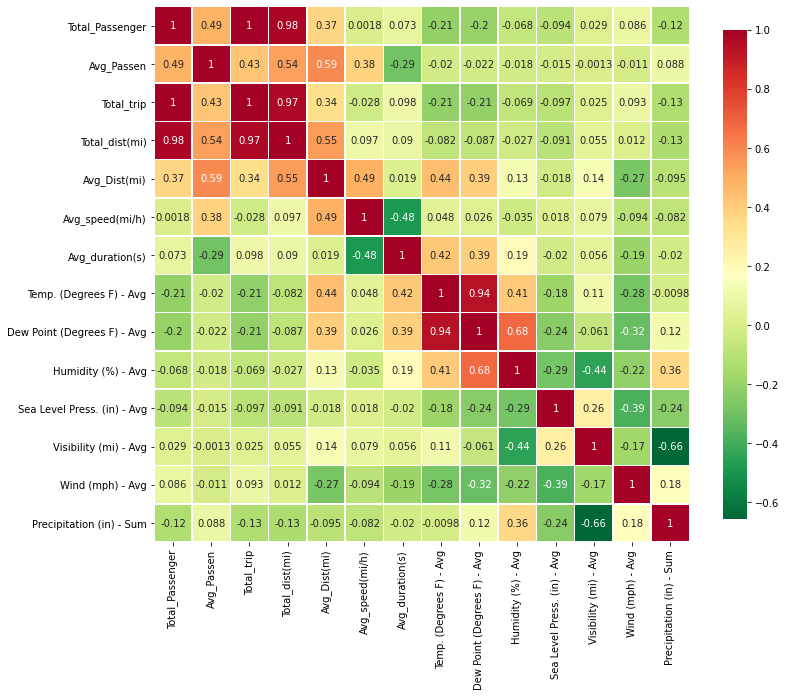

In [64]:
_, ax = plt.subplots( figsize = (12,10) )
_ = sns.heatmap(
                result_df.corr(),
                cmap='RdYlGn_r',
                square=True,
                cbar_kws= {'shrink': .9},
                ax = ax,
                annot=True,
                linewidths=.5
              )